<a href="https://colab.research.google.com/github/felipeserna/cacharreando/blob/master/deep_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [3]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [5]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [6]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars
!pip install keras-rl2
!pip install gym
!pip install gym[atari]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assau

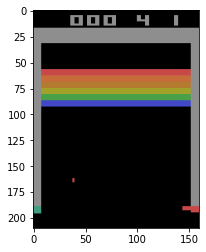

In [7]:
# From stackoverflow for displaying
env = gym.make("Breakout-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()

In [8]:
#!/usr/bin/env python3
"""
train.py
"""
import gym
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from tensorflow.keras import layers
import tensorflow.keras as K
from rl.processors import Processor
from rl.callbacks import ModelIntervalCheckpoint, FileLogger
from PIL import Image
import numpy as np


class AtariProcessor(Processor):
    """
    preprocessing
    """
    def process_observation(self, observation):
        """ resizing and grayscale """
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        # resize and convert to grayscale
        img = img.resize((84, 84), Image.ANTIALIAS).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == (84, 84)
        # saves storage in experience memory
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        """
        Rescale without using too much memory
        """
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        """ rewards between -1 and 1 """
        return np.clip(reward, -1., 1.)


def create_q_model(num_actions, window):
    """
    Preprocessing
    """
    # Network

    inputs = layers.Input(shape=(window, 84, 84))
    # comment the line below to use with GPU
    inputs_sort = layers.Permute((2, 3, 1))(inputs)

    # Change data_format="channels_first" to use GPU
    # change inputs_sort by inputs to use GPU
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu",
                           data_format="channels_last")(inputs_sort)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu",
                           data_format="channels_last")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu",
                           data_format="channels_last")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return K.Model(inputs=inputs, outputs=action)


if __name__ == '__main__':
    env = gym.make("Breakout-v0")
    env.reset()
    num_actions = env.action_space.n
    window = 4
    model = create_q_model(num_actions, window)
    model.summary()
    memory = SequentialMemory(limit=1000000, window_length=window)
    processor = AtariProcessor()

    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps',
                                  value_max=1., value_min=.1, value_test=.05,
                                  nb_steps=1000000)

    dqn = DQNAgent(model=model, nb_actions=num_actions, policy=policy,
                   memory=memory, processor=processor,
                   nb_steps_warmup=50000, gamma=.99,
                   target_model_update=10000,
                   train_interval=4,
                   delta_clip=1.)

    dqn.compile(K.optimizers.Adam(learning_rate=.00025), metrics=['mae'])
    
    dqn.fit(env,
            nb_steps=100000,
            log_interval=10000,
            visualize=False,
            verbose=2)

    dqn.save_weights('policy.h5', overwrite=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 84, 84)]       0         
_________________________________________________________________
permute (Permute)            (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               160614

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


   251/100000: episode: 1, duration: 29.944s, episode steps: 251, steps per second:   8, episode reward:  2.000, mean reward:  0.008 [ 0.000,  1.000], mean action: 1.590 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   475/100000: episode: 2, duration: 0.777s, episode steps: 224, steps per second: 288, episode reward:  1.000, mean reward:  0.004 [ 0.000,  1.000], mean action: 1.545 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   724/100000: episode: 3, duration: 0.864s, episode steps: 249, steps per second: 288, episode reward:  2.000, mean reward:  0.008 [ 0.000,  1.000], mean action: 1.454 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   907/100000: episode: 4, duration: 0.636s, episode steps: 183, steps per second: 288, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 1.525 [0.000, 3.000],  loss: --, mae: --, mean_q: --, mean_eps: --
  1243/100000: episode: 5, duration: 1.163s, episode steps: 336, steps per seco

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


 50139/100000: episode: 204, duration: 5.157s, episode steps: 224, steps per second:  43, episode reward:  1.000, mean reward:  0.004 [ 0.000,  1.000], mean action: 1.522 [0.000, 3.000],  loss: 0.004675, mae: 0.089143, mean_q: 0.135191, mean_eps: 0.954937
 50305/100000: episode: 205, duration: 3.365s, episode steps: 166, steps per second:  49, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 1.548 [0.000, 3.000],  loss: 0.003622, mae: 0.085206, mean_q: 0.122109, mean_eps: 0.954800
 50599/100000: episode: 206, duration: 5.825s, episode steps: 294, steps per second:  50, episode reward:  2.000, mean reward:  0.007 [ 0.000,  1.000], mean action: 1.463 [0.000, 3.000],  loss: 0.002908, mae: 0.083298, mean_q: 0.118661, mean_eps: 0.954593
 50770/100000: episode: 207, duration: 3.387s, episode steps: 171, steps per second:  50, episode reward:  0.000, mean reward:  0.000 [ 0.000,  0.000], mean action: 1.596 [0.000, 3.000],  loss: 0.002263, mae: 0.082979, mean_q: 0.119

In [9]:
#!/usr/bin/env python3
"""
play.py
"""
import gym
from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
import tensorflow.keras as K
from rl.policy import GreedyQPolicy
# create_q_model = __import__('train').create_q_model
# AtariProcessor = __import__('train').AtariProcessor


if __name__ == '__main__':
    env = gym.make("Breakout-v0")
    env.reset()
    num_actions = env.action_space.n
    # screenshots per state
    window = 4  
    model = create_q_model(num_actions, window)  
    memory = SequentialMemory(limit=1000000, window_length=window)
    processor = AtariProcessor()
    dqn = DQNAgent(model=model, nb_actions=num_actions,
                   policy=GreedyQPolicy(),
                   processor=processor, memory=memory)
    dqn.compile(K.optimizers.Adam(learning_rate=.00025), metrics=['mae'])

    dqn.load_weights('policy.h5')

    # Only works with 'False'
    dqn.test(env, nb_episodes=10, visualize=False)

Testing for 10 episodes ...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode 1: reward: 1.000, steps: 10000
Episode 2: reward: 0.000, steps: 10000
Episode 3: reward: 1.000, steps: 10000
Episode 4: reward: 0.000, steps: 10000
Episode 5: reward: 0.000, steps: 10000
Episode 6: reward: 0.000, steps: 10000
Episode 7: reward: 0.000, steps: 10000
Episode 8: reward: 0.000, steps: 10000
Episode 9: reward: 0.000, steps: 10000
Episode 10: reward: 0.000, steps: 10000
